# Traffic Prediction Model

This notebook contains the ML model for predicting traffic patterns.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from datetime import datetime
import warnings, os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:

# =============================================
#   1. LOAD PROCESSED or SYNTHETIC DATA
# =============================================

data_path = "../data/processed/traffic_data_processed.csv"

try:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully: {len(df)} records")
except FileNotFoundError:
    print("Processed data not found. Generating synthetic data...")

    np.random.seed(42)
    n_samples = 10000
    data = []

    for _ in range(n_samples):
        hour = np.random.randint(0, 24)
        day = np.random.randint(0, 7)
        lat = np.random.uniform(28.4, 28.7)
        lon = np.random.uniform(77.0, 77.4)
        is_weekend = 1 if day >= 5 else 0
        is_peak = 1 if (7 <= hour <= 9 or 17 <= hour <= 19) and not is_weekend else 0

        base_cong = 0.3
        if is_peak: base_cong += 0.4
        if not is_weekend: base_cong += 0.2
        if 22 <= hour or hour <= 5: base_cong -= 0.2

        congestion = np.clip(base_cong + np.random.normal(0, 0.1), 0, 1)

        data.append({
            'hour': hour,
            'day_of_week': day,
            'lat': lat,
            'lon': lon,
            'is_weekend': is_weekend,
            'is_peak_hour': is_peak,
            'congestion_level': congestion
        })

    df = pd.DataFrame(data)
    print(f"Synthetic data generated: {len(df)} records")

df.head()


Processed data not found. Generating synthetic data...
Synthetic data generated: 10000 records


,hour,day_of_week,lat,lon,is_weekend,is_peak_hour,congestion_level
0,6,3,28.685214,77.292798,0,0,0.388812
1,18,6,28.417425,77.346470,1,0,0.331890
2,3,2,28.406175,77.387964,0,0,0.253053
3,20,0,28.491273,77.209903,0,0,0.554256
4,11,0,28.487369,77.244741,0,0,0.457195



Dataset Shape: (10000, 7)

Column Types:
 hour                  int64
day_of_week           int64
lat                 float64
lon                 float64
is_weekend            int64
is_peak_hour          int64
congestion_level    float64
dtype: object

Missing Values:
 hour                0
day_of_week         0
lat                 0
lon                 0
is_weekend          0
is_peak_hour        0
congestion_level    0
dtype: int64

Basic Statistics:
                hour   day_of_week           lat           lon    is_weekend  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      11.575400      3.020800     28.550586     77.200639      0.292200   
std        6.910824      2.009669      0.085990      0.114914      0.454796   
min        0.000000      0.000000     28.400003     77.000007      0.000000   
25%        6.000000      1.000000     28.476695     77.101442      0.000000   
50%       12.000000      3.000000     28.551256     77.201556      0

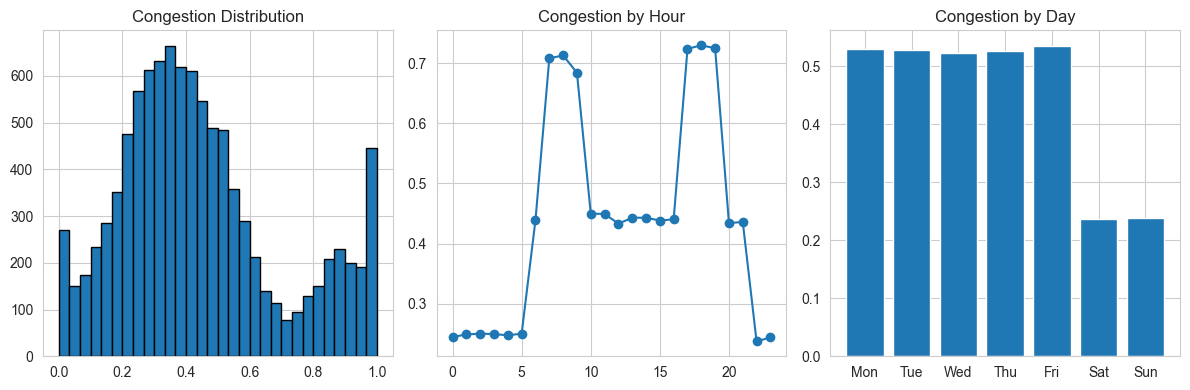

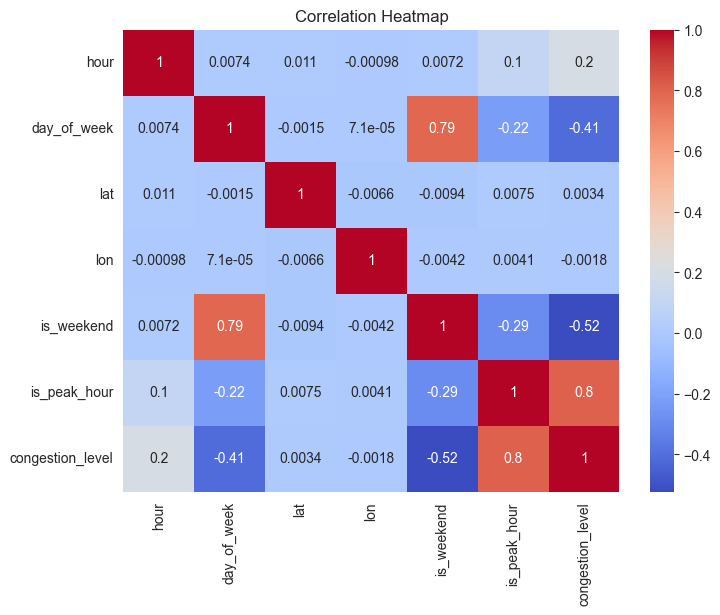

In [4]:

# =============================================
#   2. BASIC STATS
# =============================================

print("\nDataset Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nBasic Statistics:\n", df.describe())

# =============================================
#   3. EDA PLOTS
# =============================================

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(df['congestion_level'], bins=30, edgecolor='black')
plt.title("Congestion Distribution")

plt.subplot(1,3,2)
plt.plot(df.groupby('hour')['congestion_level'].mean(), marker='o')
plt.title("Congestion by Hour")

plt.subplot(1,3,3)
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.bar(days, df.groupby('day_of_week')['congestion_level'].mean())
plt.title("Congestion by Day")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[['hour','day_of_week','lat','lon','is_weekend','is_peak_hour','congestion_level']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [5]:

# =============================================
#   4. FEATURE ENGINEERING
# =============================================

feature_columns = ['hour','day_of_week','lat','lon','is_weekend','is_peak_hour']
target_column = 'congestion_level'

X = df[feature_columns]
y = df[target_column]

print("\nX shape:", X.shape)
print("y shape:", y.shape)



X shape: (10000, 6)
y shape: (10000,)


In [6]:

# =============================================
#   5. TRAIN-TEST SPLIT + SCALING
# =============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")



Training samples: 8000
Test samples: 2000


In [7]:

# =============================================
#   6. TRAIN RANDOM FOREST
# =============================================

rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

print("\nRandom Forest training done.")



Random Forest training done.


In [8]:

# =============================================
#   7. TRAIN GRADIENT BOOSTING
# =============================================

gb_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
)
gb_model.fit(X_train_scaled, y_train)
y_train_pred_gb = gb_model.predict(X_train_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)

print("\nGradient Boosting training done.")



Gradient Boosting training done.


In [9]:

# =============================================
#   8. EVALUATION FUNCTION
# =============================================

def eval_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n{name}")
    print("MSE :", mse)
    print("RMSE:", rmse)
    print("MAE :", mae)
    print("R2  :", r2)

    return mse, rmse, mae, r2

print("\n=== RANDOM FOREST ===")
rf_test_metrics = eval_model(y_test, y_test_pred_rf, "RF Test")

print("\n=== GRADIENT BOOSTING ===")
gb_test_metrics = eval_model(y_test, y_test_pred_gb, "GB Test")



=== RANDOM FOREST ===

RF Test
MSE : 0.009008545097880535
RMSE: 0.09491335574027786
MAE : 0.07617821285506433
R2  : 0.8607891105907385

=== GRADIENT BOOSTING ===

GB Test
MSE : 0.009073081398350624
RMSE: 0.0952527238369099
MAE : 0.07668067150680628
R2  : 0.8597918179435897


In [10]:

# =============================================
#   9. PREDICTIONS FOR CUSTOM SCENARIOS
# =============================================

scenarios = [
    {'hour':8,'day_of_week':1,'lat':28.6139,'lon':77.2090,'is_weekend':0,'is_peak_hour':1,'name':'Monday 8 AM'},
    {'hour':14,'day_of_week':1,'lat':28.6139,'lon':77.2090,'is_weekend':0,'is_peak_hour':0,'name':'Monday 2 PM'},
    {'hour':23,'day_of_week':1,'lat':28.6139,'lon':77.2090,'is_weekend':0,'is_peak_hour':0,'name':'Monday 11 PM'},
]

def label_congestion(v):
    if v < 0.3: return "LOW"
    elif v < 0.6: return "MODERATE"
    elif v < 0.8: return "HIGH"
    else: return "SEVERE"

print("\n=== SAMPLE PREDICTIONS ===")
for s in scenarios:
    inp = np.array([[s['hour'], s['day_of_week'], s['lat'], s['lon'], s['is_weekend'], s['is_peak_hour']]])
    inp_scaled = scaler.transform(inp)

    rf_pred = rf_model.predict(inp_scaled)[0]
    gb_pred = gb_model.predict(inp_scaled)[0]

    print(f"\n{s['name']}:")
    print("RF:", rf_pred, label_congestion(rf_pred))
    print("GB:", gb_pred, label_congestion(gb_pred))



=== SAMPLE PREDICTIONS ===

Monday 8 AM:
RF: 0.902157094350553 SEVERE
GB: 0.902436709911341 SEVERE

Monday 2 PM:
RF: 0.5054248858151453 MODERATE
GB: 0.4992091841222921 MODERATE

Monday 11 PM:
RF: 0.2918717839880184 LOW
GB: 0.300982607510015 MODERATE


In [15]:

# =============================================
#   10. SAVE MODELS (Correct Folder)
# =============================================

NOTEBOOK_DIR = os.path.dirname(os.path.abspath(""))
PROJECT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../../"))

save_dir = os.path.join(PROJECT_DIR, "Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models")
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Timestamped files
rf_ts   = os.path.join(save_dir, f"traffic_rf_eda_{timestamp}.pkl")
gb_ts   = os.path.join(save_dir, f"traffic_gb_eda_{timestamp}.pkl")
sc_ts   = os.path.join(save_dir, f"traffic_scaler_eda_{timestamp}.pkl")

# Default (overwrite)
rf_def  = os.path.join(save_dir, "traffic_rf_eda.pkl")
gb_def  = os.path.join(save_dir, "traffic_gb_eda.pkl")
sc_def  = os.path.join(save_dir, "traffic_scaler_eda.pkl")

joblib.dump(rf_model, rf_ts)
joblib.dump(gb_model, gb_ts)
joblib.dump(scaler, sc_ts)

joblib.dump(rf_model, rf_def)
joblib.dump(gb_model, gb_def)
joblib.dump(scaler, sc_def)

print("\n=== MODELS SAVED ===")
print(rf_ts)
print(gb_ts)
print(sc_ts)

print("\nDefault models written to:")
print(rf_def)
print(gb_def)
print(sc_def)



=== MODELS SAVED ===
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models\traffic_rf_eda_20251128_173315.pkl
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models\traffic_gb_eda_20251128_173315.pkl
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models\traffic_scaler_eda_20251128_173315.pkl

Default models written to:
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models\traffic_rf_eda.pkl
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models\traffic_gb_eda.pkl
c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-ma

In [16]:

# =============================================
#   11. SUMMARY
# =============================================

print("\n========================================")
print("           TRAINING SUMMARY")
print("========================================")
print("Total samples:", len(df))
print("Best model:", "RF" if rf_test_metrics[3] > gb_test_metrics[3] else "GB")
print("Models saved to:", save_dir)
print("========================================")



           TRAINING SUMMARY
Total samples: 10000
Best model: RF
Models saved to: c:\Users\aparn\Desktop\prgrmng\.vscode\Python\Desktop\prgrmng\.vscode\Python\KatathonGeosenseProject-main\ml_models\saved_models\eda_models
